<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

## 1) *Optional:* Scrape 100 Job Listings that contain the title "Data Scientist" from indeed.com

At a minimum your final dataframe of job listings should contain
- Job Title
- Job Description

If you choose to not to scrape the data, there is a CSV with outdated data in the directory. Remeber, if you scrape Indeed, you're helping yourself find a job. ;)

Using [this article](https://medium.com/@msalmon00/web-scraping-job-postings-from-indeed-96bd588dcb4b) as a guideline.

In [2]:
import requests
import bs4
from bs4 import BeautifulSoup

import pandas as pd
import time

In [3]:
# Practice on a single page

URL = "https://www.indeed.com/jobs?q=data+scientist&l=Los+Angeles%2C+CA"

page = requests.get(URL)

soup = BeautifulSoup(page.text, 'html.parser')

print(soup.prettify())

<!DOCTYPE html>
<html dir="ltr" lang="en">
 <head>
  <meta content="text/html;charset=utf-8" http-equiv="content-type"/>
  <script src="/s/077d714/en_US.js" type="text/javascript">
  </script>
  <link href="/s/b066150/jobsearch_all.css" rel="stylesheet" type="text/css"/>
  <link href="http://rss.indeed.com/rss?q=data+scientist&amp;l=Los+Angeles%2C+CA" rel="alternate" title="Data Scientist Jobs, Employment in Los Angeles, CA" type="application/rss+xml"/>
  <link href="/m/jobs?q=data+scientist&amp;l=Los+Angeles%2C+CA" media="only screen and (max-width: 640px)" rel="alternate"/>
  <link href="/m/jobs?q=data+scientist&amp;l=Los+Angeles%2C+CA" media="handheld" rel="alternate"/>
  <script type="text/javascript">
   if (typeof window['closureReadyCallbacks'] == 'undefined') {
window['closureReadyCallbacks'] = [];
}

function call_when_jsall_loaded(cb) {
if (window['closureReady']) {
cb();
} else {
window['closureReadyCallbacks'].push(cb);
}
}
  </script>
  <meta content="1" name="ppstriptst"/

In [4]:
# Get titles

def extract_titles(html):
    titles = []
    for div in html.find_all(name='div', attrs={'class': 'title'}):
        for a in div.find_all(name='a', attrs={'class': 'jobtitle turnstileLink'}):
            titles.append(a['title'])
    
    return titles

extract_titles(soup)

['Machine Learning Engineer',
 'Data Scientist – Organizational Performance',
 'Data Scientist',
 'Data Scientist (Remote)',
 'Senior HR Data Analyst',
 'Data Scientist (Analytics)',
 'Data Scientist',
 'Data Scientist',
 'Data Scientist',
 'Commuter & Parking Programs Data Scientist',
 'Data Scientist',
 'Fandango-Data Scientist',
 'Data Analyst/Data Scientist',
 'Data Scientist - Disney+',
 'Senior Data Scientist',
 'Data Scientist/Visualization Master',
 'Senior Data Scientist',
 'Senior Data Scientist - Advanced Analytics (763882)']

In [5]:
# Get descriptions

def extract_desc(html):
    descriptions = []
    for div in html.find_all(name='div', attrs={'class': 'title'}):
        for a in div.find_all(name='a', attrs={'class': 'jobtitle turnstileLink'}):
            # This HTML block contains a URL to a page that contains the full description.
            # But it's an incomplete URL, so I need to complete it.
            URL2 = 'https://www.indeed.com' + a['href']
            page2 = requests.get(URL2)
            soup2 = BeautifulSoup(page2.text, 'html.parser')
            description = soup2.find(name='div', attrs={'id': 'jobDescriptionText'})
            # The above gets me the entire description; I'll use the get_text method
            # to cut out all the HTML tags.
            descriptions.append(description.get_text())
            
    return descriptions

practice = extract_desc(soup)

len(practice)

18

In [6]:
practice[0]

'About TriplebyteTriplebyte helps companies find and hire great technical talent. For any company building software, this is crucial for success. A recent survey of top C-Level Executives, across multiple industries, showed that software, R&D and recruiting technical talent are the top areas they are planning increased investment and budget over the next 5 years. Companies like Apple, Dropbox and American Express trust Triplebyte’s online technical assessment to identify the best engineers for their open roles and reduce the time and effort it takes to hire them.Earlier this year we raised a $35 million Series B and our team of 40 will double in size during 2019. Now is a great time to join as we\'re on an exciting growth trajectory. You will have lots of opportunity for taking on responsibility and developing new skills quickly.We have built Machine Learning models that predict the likelihood of an engineer getting an offer from a particular company. Interviewing and assessing enginee

In [7]:
titles = extract_titles(soup)

descriptions = extract_desc(soup)

for n in [10, 20, 30, 40, 50, 60]:
    URL3 = f'https://www.indeed.com/jobs?q=data+scientist&l=Los+Angeles%2C+CA&start={n}'
    page3 = requests.get(URL3)
    soup3 = BeautifulSoup(page3.text, 'html.parser')
    
    new_titles = extract_titles(soup3)
    # I can't just append this directly to 'titles,' since then 'titles' would be a list of lists.
    # Instead I need to append each title individually.
    for title in new_titles:
        titles.append(title)
    new_desc = extract_desc(soup3)
    for desc in new_desc:
        descriptions.append(desc)
    
print(len(titles))

print(len(descriptions))

111
111


In [8]:
data = {'title': titles, 'description': descriptions}

df = pd.DataFrame(data=data)

print(df.shape)

df.head()

(111, 2)


,title,description
0,Machine Learning Engineer,About TriplebyteTriplebyte helps companies fin...
1,Data Scientist – Organizational Performance,Job Description\nSouthern California Edison is...
2,Data Scientist,Onward Search is on the hunt for a Data Scient...
3,Data Scientist (Remote),About Kraken\n\nOur mission is to accelerate t...
4,Senior HR Data Analyst,Job Title: Senior HR Data Analyst\nJob ID: 101...


## 2) Use Spacy to tokenize / clean the listings 

In [9]:
nlp = spacy.load('en_core_web_lg')

In [10]:
tokenized = []

for desc in df['description']:
    doc = nlp(str(desc))
    tokens = ''
    for token in doc:
        if (token.is_stop is not True) and (token.is_punct is not True):
            # CountVectorizer wants a single string, not a list.
            tokens = tokens + ' ' + str(token)
    tokenized.append(tokens)
    
tokenized[0]

" TriplebyteTriplebyte helps companies find hire great technical talent company building software crucial success recent survey C Level Executives multiple industries showed software R&D recruiting technical talent areas planning increased investment budget 5 years Companies like Apple Dropbox American Express trust Triplebyte ’s online technical assessment identify best engineers open roles reduce time effort takes hire Earlier year raised $ 35 million Series B team 40 double size 2019 great time join exciting growth trajectory lots opportunity taking responsibility developing new skills quickly built Machine Learning models predict likelihood engineer getting offer particular company Interviewing assessing engineering talent tends noisy technical assessment proven good extract meaningful signals collect data interview results house evaluations gives unique dataset play data deliver 40 conversion rate candidates interview offer compared industry standard 20%.Our mission create scienti

In [11]:
df['tokenized'] = tokenized

print(df.shape)

df.head()

(111, 3)


,title,description,tokenized
0,Machine Learning Engineer,About TriplebyteTriplebyte helps companies fin...,TriplebyteTriplebyte helps companies find hir...
1,Data Scientist – Organizational Performance,Job Description\nSouthern California Edison is...,Job Description \n Southern California Edison...
2,Data Scientist,Onward Search is on the hunt for a Data Scient...,Onward Search hunt Data Scientist join Digita...
3,Data Scientist (Remote),About Kraken\n\nOur mission is to accelerate t...,Kraken \n\n mission accelerate adoption crypt...
4,Senior HR Data Analyst,Job Title: Senior HR Data Analyst\nJob ID: 101...,Job Title Senior HR Data Analyst \n Job ID 10...


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [12]:
vect = CountVectorizer()

dtm = vect.fit_transform(df['tokenized'])

dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())

dtm.head()

,00,000,00am,00pm,0106connect,04,05784,09,10,100,...,yield,yieldbook,yj8fnyw3hn,yoga,young,youth,youtu,youtube,zealous,zettabytes
0,2,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 4) Visualize the most common word counts

In [13]:
# It'll be easiest to make a new dataframe, where I add up all the individual word counts from dtm.

counts = []

for column in dtm.columns:
    counts.append(sum(dtm[column]))
    
data = {'word': dtm.columns, 'count': counts}

df2 = pd.DataFrame(data=data)

df2.head()

,word,count
0,00,51
1,000,76
2,00am,2
3,00pm,2
4,0106connect,3


In [14]:
df2 = df2.sort_values(by='count', ascending=False)

df2.head(10)

,word,count
968,data,1265
1412,experience,513
534,business,384
4036,work,318
3262,science,258
257,analytics,248
2125,learning,242
3669,team,224
245,analysis,200
4069,years,180


In [15]:
total_count = sum(df2['count'])
pcts = []
for n in df2['count']:
    pct_total = n / total_count
    pcts.append(pct_total)
    
df2['pct_total'] = pcts

df2.head()

,word,count,pct_total
968,data,1265,0.032481
1412,experience,513,0.013172
534,business,384,0.009860
4036,work,318,0.008165
3262,science,258,0.006625


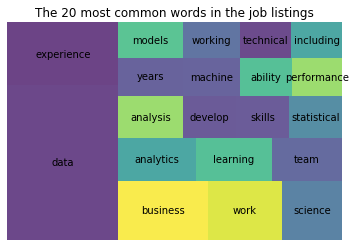

In [16]:
import squarify
import matplotlib.pyplot as plt

df2 = df2.reset_index(drop=True)

top20 = df2.loc[0:19]

squarify.plot(sizes=top20['pct_total'], label=top20['word'], alpha=.8)
plt.axis('off')
plt.title('The 20 most common words in the job listings')
plt.show()

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [17]:
tfidf = TfidfVectorizer(stop_words='english')

dtm = tfidf.fit_transform(df['tokenized'])

dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

print(dtm.shape)

dtm.head()

(111, 4059)


,00,000,00am,00pm,0106connect,04,05784,09,10,100,...,yield,yieldbook,yj8fnyw3hn,yoga,young,youth,youtu,youtube,zealous,zettabytes
0,0.07266,0.056889,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.00000,0.014944,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [18]:
from sklearn.neighbors import NearestNeighbors

nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [27]:
# To be honest, I don't really have an ideal job...so I'll just write whatever.

ideal_job = """This job pays a lot of money, and you only have to work 40 hours a week--no unpaid overtime!
Our location is close to a train station as well as a wide variety of good, reasonably-priced restaurants.
And don't worry--we're unionized! Indeed, we plan on becoming a cooperative in the near future."""

vector_rep = tfidf.transform([ideal_job]).todense()

nn.kneighbors(vector_rep)

(array([[1.36665322, 1.37205741, 1.37205741, 1.37205741, 1.37205741]]),
 array([[ 30,  76,   0, 107,  92]], dtype=int64))

In [29]:
print(df.iloc[30,0])

print(df.iloc[30,1])

# Damn, they require 5 years experience...

Data Scientist / Data Analytics Manager– Financial Institution
Location: Gardena, CA

Data Scientist / Data Analytics Manager
As NGFCU's Data Scientist / Data Analytics Manager, you will be responsible to identify and implement data analytics applications for the credit union by (a) collaborating with business leaders to meet their needs and (b) discovering new ways to take advantage of the data through your own investigations. You will be responsible to create, through the selection and deployment of vendor capabilities, the integrated data sources that will enable the fulfillment of these needs, as well as the data visualization and dashboarding techniques necessary to exploit the integrated data warehouse. You will oversee "superuser" data application developers and business intelligence analysts on both a centralized basis and across the various departments / data users, and/or vendor application providers. You will implement data governance and data management protocols in support

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 